# Data Exploration

Idea is to look at various datasets for the region of interest (+ presumably wider region as well) to look for interesting patterns (extreme weather events, large-scale weather structures etc)

Rainfall: https://www.sciencedirect.com/science/article/pii/S0022169424012666

In [ ]:
## imports
import time
import logging
logging.basicConfig(level='INFO')

import typing

import pandas as pd
import xarray as xr
import numpy as np

import cdsapi
from ecmwf.datastores import Client
import earthkit as ek
import earthkit.data as ekd
import earthkit.plots as ekp

import matplotlib as mpl
import matplotlib.pyplot as plt

REQUEST = False

print('Imports complete')

In [ ]:
## constants
# N W S E

SE_CHINA_BBOX = [31.7, 115.0, 23.3, 123.2] ## covers fujian, zhejiang, southmost bit of anhui, bit of taiwan
FZ_BBOX = [26.1, 119.3, 26.1, 119.3]

FZ_SURROUND_BBOX = list(np.array(FZ_BBOX) + [5, -5, -5, 5])

In [ ]:
years = [str(yr) for yr in range(1940, 2025)]
months = [[f'{str(i):0>2}' for i in range(1, 13)]]

REQUEST = False

request = {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': ['total_precipitation'],
        'year': years,
        'month': months,
        'time': ['00:00'],
        'data_format': 'netcdf',
        'download_format': 'unarchived',
        'area': FZ_BBOX
}

if REQUEST:
    data = ekd.from_source(
        'cds', 'reanalysis-era5-single-levels-monthly-means', request
    )

    ds = data.to_xarray()
    ds.to_zarr('./FZ_precipitation')
else:
    ds = xr.open_zarr('./FZ_precipitation')

select lat/lon (to reduce from 3D->1D), rename column to time, convert from m to mm

In [ ]:
## change units to mm
tp = ds.isel(latitude=0, longitude=0).rename({'valid_time':'time'}).tp * 1000

## mean-centre data
tp_mean = tp.mean()
tp = tp - tp_mean

## max precipitation

# tp = tp.isel(time=slice(880, 910, None))

wettest_month_idx = int(tp.argmax())
wettest_month_data = tp.isel(time=wettest_month_idx)

wettest_month = wettest_month_data.time.compute()
max_precip = wettest_month_data.data.compute()

mean_precip = int(tp.mean())
rolling_mean = tp.rolling(time=12).mean()

## trend
x = np.arange(len(tp))
slope, intercept = np.polyfit(x, tp, 1)
trendline = slope * x  + intercept

warming_rate = slope * 120

seasonal = tp.rolling(time=240, center=True).mean()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 6))

#pplot = tp.plot(color='blue', linewidth=0.2, alpha=0.3, label='Monthly', ax=ax)
mplot = rolling_mean.plot(color='orange', linewidth=1, alpha=0.5, label='12-month Rolling Mean', ax=ax)
rplot = seasonal.plot(color='red', linewidth=2, alpha=0.9, label='20-year Rolling Mean', ax=ax)
tplot = ax.plot(tp.time.values, trendline, linestyle='dashed', color='black', label=f'Trendline (+{warming_rate:.2f}°C/decade)')

ax.set_xlabel(f'Precipitation anomaly (mm)')

ax.legend()
ax.set_title(f'Precipitation anomaly at 26.1N, 119.3E (Mean = {tp_mean.compute().data:.2f}mm)')

plt.show()

In [ ]:
FZ_SURROUND_BBOX

In [61]:
## FZ TP

years = [str(yr) for yr in range(1940, 2025)]
months = [f'{str(i):0>2}' for i in range(1, 13)]

REQUEST = False

request = {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': ['mean_sea_level_pressure'],
        'year': years,
        'month': months,
        'time': ['00:00'],
        'data_format': 'netcdf',
        'download_format': 'unarchived',
        'area': FZ_SURROUND_BBOX
}

if REQUEST:
    data = ekd.from_source(
        'cds', 'reanalysis-era5-single-levels-monthly-means', request
    )

    ds = data.to_xarray()
    ds.to_zarr('./FZ_area_sl_pressure', mode='w')

else:
    ds = xr.open_zarr('./FZ_area_sl_pressure')

In [38]:
## TOTAL MSL

years = [str(yr) for yr in range(1940, 2025)]
months = [f'{str(i):0>2}' for i in range(1, 13)]

REQUEST = False

request = {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': ['tp', 'msl'],
        'year': '2022',
        'month': '06',
        'time': ['00:00'],
        'data_format': 'netcdf',
        'download_format': 'unarchived',
        'area': FZ_SURROUND_BBOX
}

if REQUEST:
    data = ekd.from_source(
        'cds', 'reanalysis-era5-single-levels-monthly-means', request
    )

    ds = data.to_xarray()

else:
    ds = xr.open_zarr('./FZ_area_sl_pressure')

In [50]:
## FZ AREA ALL

mag = 10
FZ_AREA_BBOX = list(np.array(FZ_BBOX) + np.array([1, -1, -2, 2])*5)

years = [1947]
months = [f'{str(i):0>2}' for i in range(1, 13)]

REQUEST = True

request = {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': ['tp', 'msl'],
        'year': '2022',
        'month': '06',
        'time': ['00:00'],
        'data_format': 'netcdf',
        'download_format': 'unarchived',
        'area': FZ_AREA_BBOX
}

if REQUEST:
    data = ekd.from_source(
        'cds', 'reanalysis-era5-single-levels-monthly-means', request
    )

    ds = data.to_xarray()

else:
    ds = xr.open_zarr('./FZ_area_sl_pressure')

2026-02-05 11:29:31,414 INFO Request ID is 9c409123-5ca9-4de2-bf52-306b5d2e27f6
INFO:ecmwf.datastores.legacy_client:Request ID is 9c409123-5ca9-4de2-bf52-306b5d2e27f6
2026-02-05 11:29:31,485 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2026-02-05 11:29:45,448 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running
2026-02-05 11:29:53,114 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:443/cci2-prod-cache-2/2026-02-03/b2be24ca5522c898214b35036437c62e.zip


In [ ]:
## FZ AREA ALL

mag = 10
LARGE_BBOX = [30.3, 114.3, 0.2, -109.2]

years = [1947]
months = [f'{str(i):0>2}' for i in range(1, 13)]

REQUEST = True

request = {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': 'mean_sea_level_pressure',
        'year': [int(i) for i in range(1979, 2023)],
        'month': months,
        'time': ['00:00'],
        'data_format': 'netcdf',
        'download_format': 'unarchived',
        'area': LARGE_BBOX
}

if REQUEST:
    data = ekd.from_source(
        'cds', 'reanalysis-era5-single-levels-monthly-means', request
    )

    ds = data.to_xarray()
    ds.to_zarr('./NPacific_msl')

else:
    ds = xr.open_zarr('./NPacific_msl')

2026-02-05 11:55:07,965 INFO Request ID is ec21640a-57e2-4a50-9aba-490c41c82fe9
INFO:ecmwf.datastores.legacy_client:Request ID is ec21640a-57e2-4a50-9aba-490c41c82fe9
2026-02-05 11:55:08,047 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2026-02-05 11:55:21,616 INFO status has been updated to running
INFO:ecmwf.datastores.legacy_client:status has been updated to running


In [63]:
import xeofs
from xeofs.single import EOF

model = EOF(n_modes=4, standardize=True, use_coslat=True)
model.fit(ds, dim='valid_time')

In [66]:
# Get the EOFs (spatial patterns) and PCs (time series)
eofs = model.components()  # Spatial patterns
pcs = model.scores()  # Principal components (time series), standardized
variance_fractions = model.explained_variance_ratio()  # Fraction of variance explained

print("\nVariance explained by each EOF:")
for i in range(4):
    print(f"  EOF {i+1}: {variance_fractions.values[i]*100:.1f}%")
print(f"\nTotal variance explained by first {4} EOFs: {variance_fractions.values.sum()*100:.1f}%")


Variance explained by each EOF:
  EOF 1: 98.5%
  EOF 2: 1.3%
  EOF 3: 0.1%
  EOF 4: 0.0%

Total variance explained by first 4 EOFs: 99.9%


In [105]:
eofs.sel(mode=1).msl.values

array([[0.02492248, 0.02491633, 0.02490935, ..., 0.02403095, 0.0239675 ,
        0.02390283],
       [0.02492093, 0.02491603, 0.0249104 , ..., 0.02409507, 0.02403366,
        0.02397186],
       [0.02491673, 0.0249129 , 0.02490845, ..., 0.02415584, 0.02409744,
        0.02403709],
       ...,
       [0.02368809, 0.02370044, 0.02371301, ..., 0.02394867, 0.0239499 ,
        0.02395031],
       [0.02364575, 0.02365839, 0.02367079, ..., 0.0239047 , 0.02390631,
        0.02390734],
       [0.02359845, 0.02361179, 0.02362236, ..., 0.02385952, 0.02386158,
        0.02386287]], shape=(41, 41))

c:\Users\nookh\miniconda3\envs\ml_ff\Lib\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\nookh\miniconda3\envs\ml_ff\Lib\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


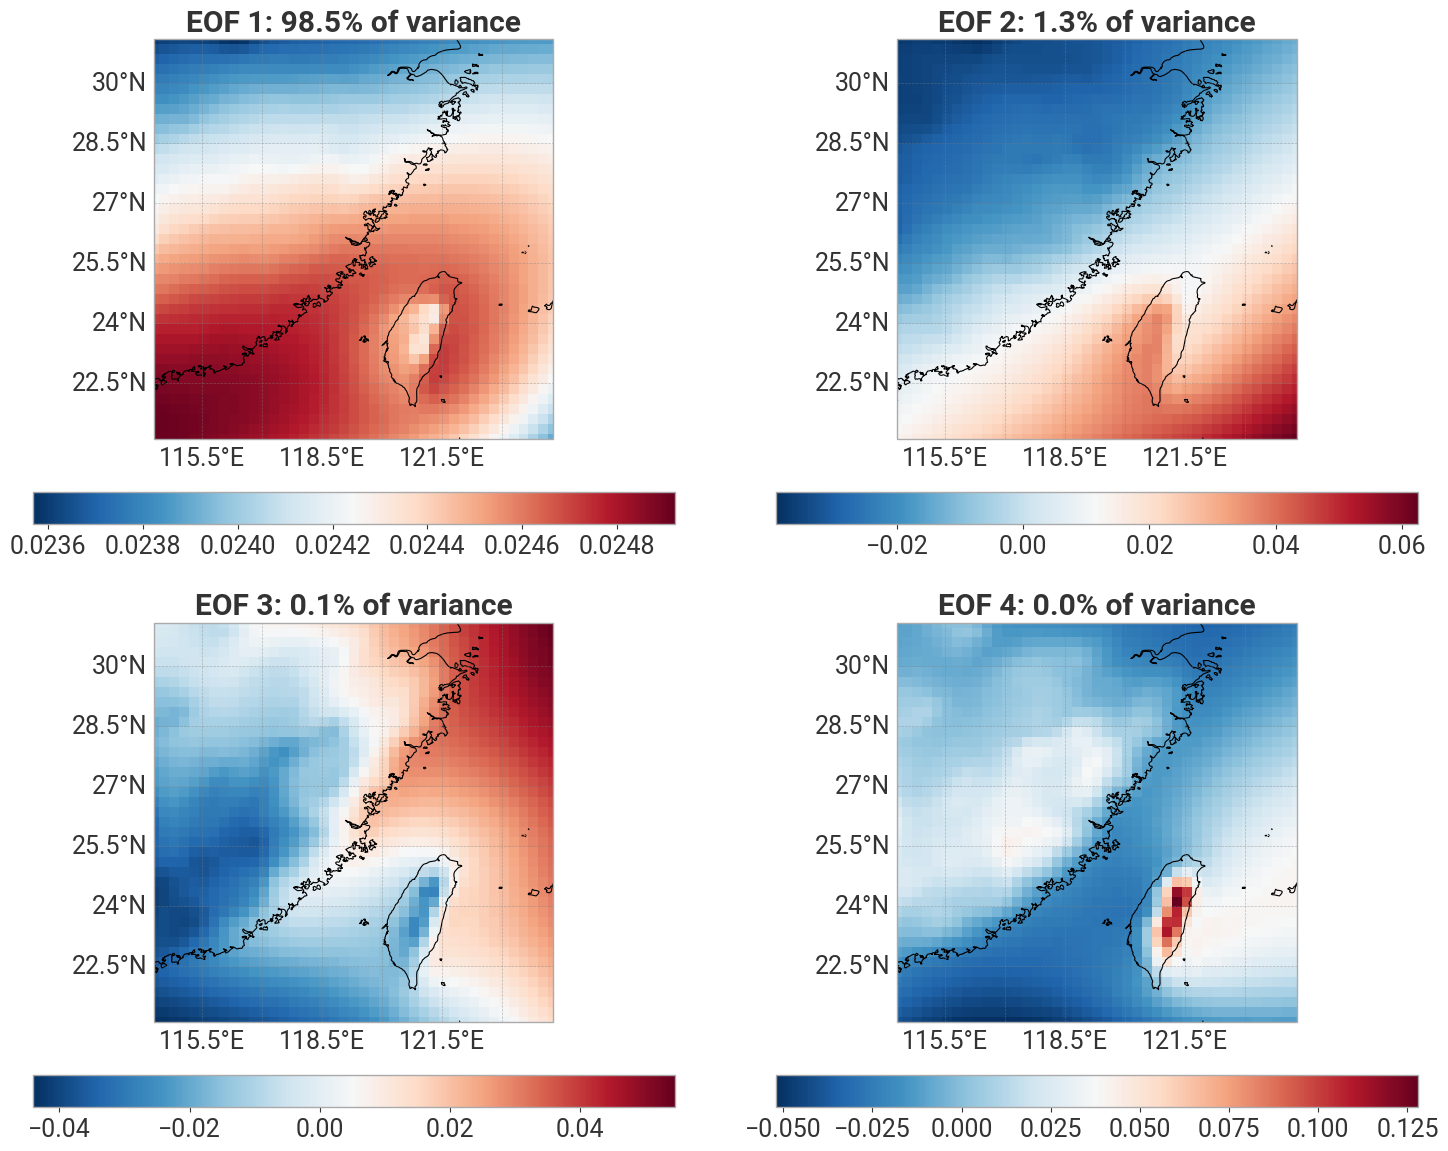


Plot saved as 'eof_patterns.png'


In [107]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# Plot the 4 leading EOFs
fig, axes = plt.subplots(2, 2, figsize=(16, 12),
                         subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

# Set the default font and figure size
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 18

for i in range(4):
    ax = axes[i]
    eof_pattern = eofs.sel(mode=i+1)  # xeofs uses 1-based indexing

    # Set map extent
    ax.set_extent([FZ_SURROUND_BBOX[1], FZ_SURROUND_BBOX[3],
                   FZ_SURROUND_BBOX[2], FZ_SURROUND_BBOX[0]],
                  crs=ccrs.PlateCarree())

    # Plot EOF pattern
    X, Y = np.meshgrid(eof_pattern.longitude, eof_pattern.latitude)

    im = ax.pcolormesh(
        X, Y,
        eof_pattern.msl.values,
        transform=ccrs.PlateCarree(),
        cmap='RdBu_r'
    )

    # Add map features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='#f0f0f0', alpha=0.5)

    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray',
                      alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # Title with variance explained
    ax.set_title(f'EOF {i+1}: {variance_fractions.values[i]*100:.1f}% of variance', fontweight='bold')

    # Add colorbar
    plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.1, shrink=0.8)

plt.tight_layout()
plt.show()

print("\nPlot saved as 'eof_patterns.png'")

In [ ]:
pressure_style = ekp.styles.Contour(
    units="hPa",
    labels=True,
    linewidths=np.array([0.25, 0.25, 0.25, 0.75])*2,
    linecolors='white'
)

precip_style = ekp.styles.Style(
    colors='viridis',
    extend='both'
)

chart = ekp.Map()

chart.quickplot(ds.isel(valid_time=-1).compute().tp, style=precip_style)
chart.quickplot(ds.isel(valid_time=0).compute().msl, style=pressure_style)

chart.coastlines()
chart.borders()
chart.gridlines()

chart.legend()
chart.show()